<h1 style="font-size:50px; text-align: center; margin-bottom: 10px">Sensitivity Curves Demo</h1>
This notebook contains a demo of how to plot LISA sensitivity curves using this code. Additionally, we explore how different mission lengths affect the sensitivity curve and overlay signals from simulated binaries. In particular, we show the relative merits of plotting characteristic strain and amplitude spectral density (ASD).

Note: This demo assumes you've already read the strain calculation demo

In [429]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
import matplotlib.colors as colors

from importlib import reload

# import sensitivity curves code from '/code' folder
import sys
sys.path.append("../LISA_detections")
import sensitivity_curves as sc
import strain_calculations as str_calc
reload(sc)
reload(str_calc)

%config InlineBackend.figure_format = 'retina'
plt.rc("font", family="serif")
fs = 20

# Plot the LISA sensitivity curve
Plotting the LISA sensitivity curve is as simple as the following code. Try out changing some stylistic aspects of the plot by altering the `shade=True` flag and altering the `color` value.

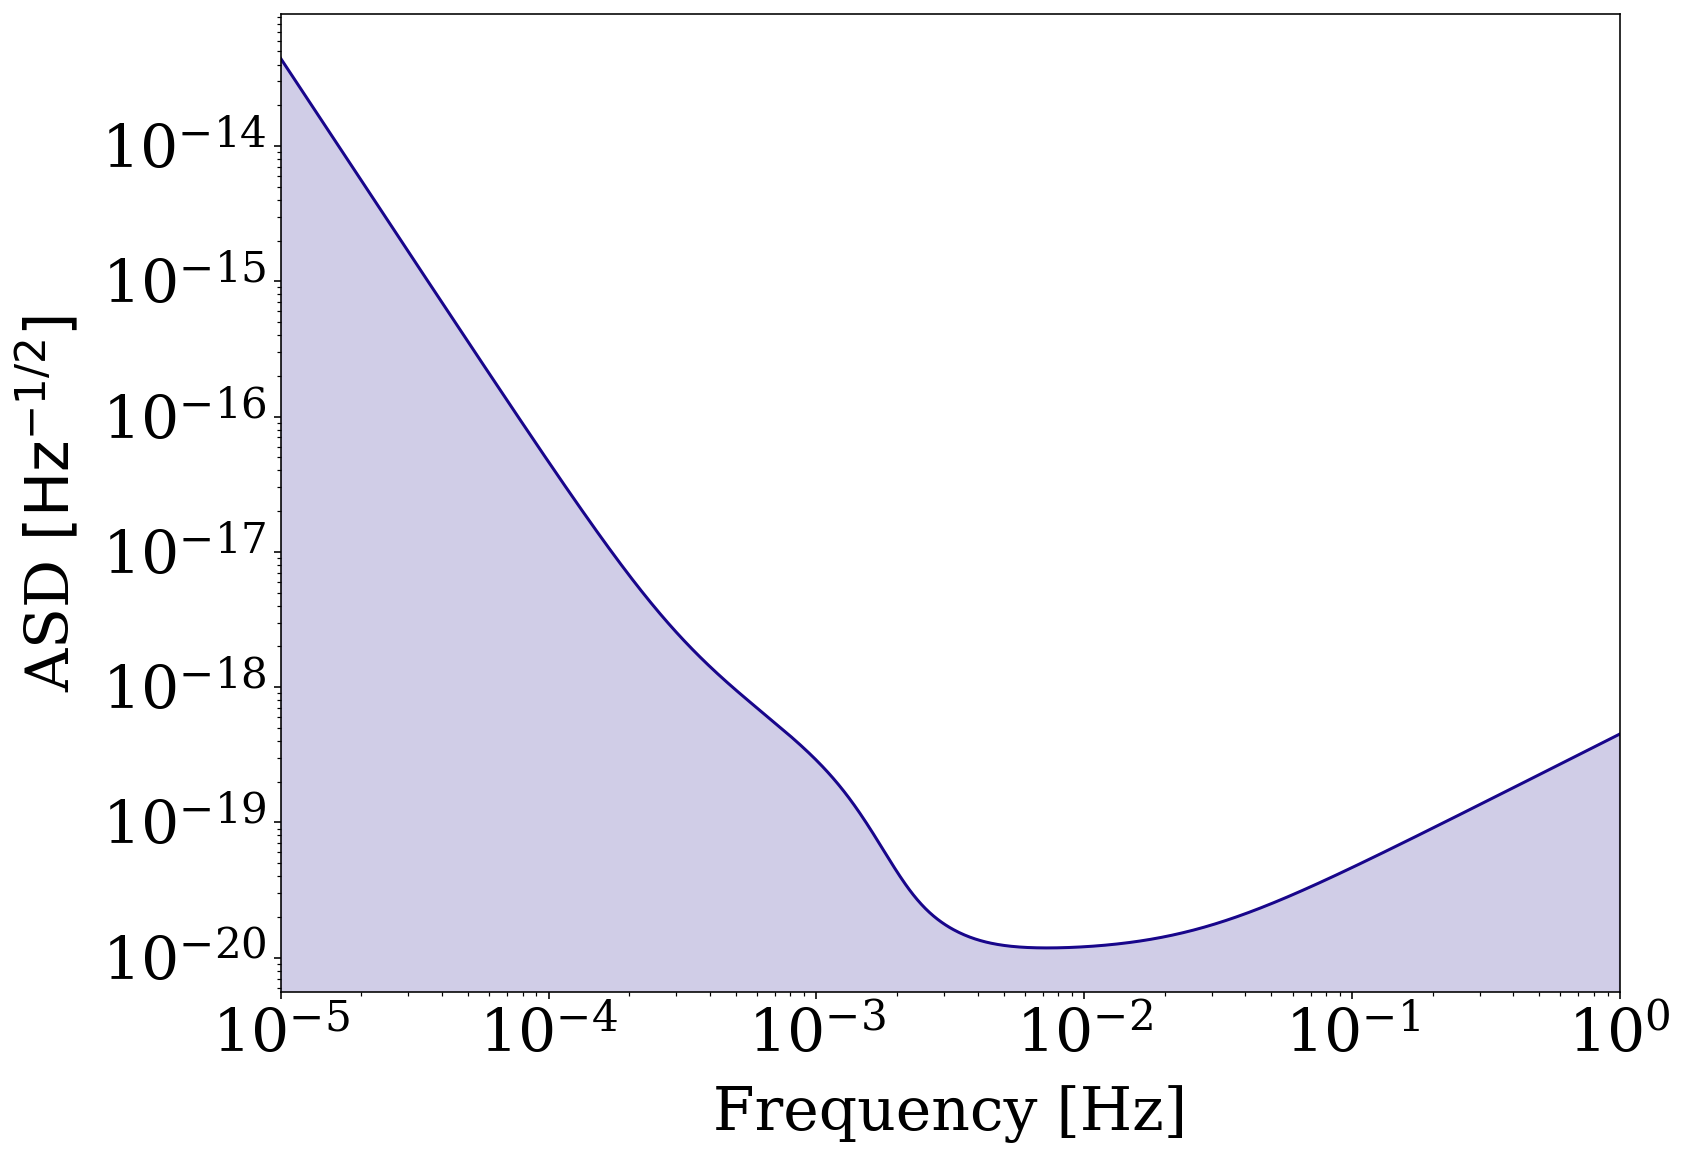

In [430]:
# these are default values for shade and color, only included so it is obvious how to change them
fig, ax = sc.plot_sensitivity_curve(sc.LISA_Sn, shade=True, color="#18068b")
plt.show()

# Effect of Mission Length
Below, we show how the shape of the sensitivity curve changes by altering the mission length. This change is because the galactic confusion noise decreases over the mission, as explained in [Robson et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019CQGra..36j5011R/abstract) around Eq. 14. They explain that over the course of the mission the number of unresolved sources decreases and so the confusion noise is reduced as foreground sources are removed.

Their paper includes parameters for 0.5, 1, 2 and 4 years, so we find the closest of these four to the inputted time and use the corresponding parameter values. We can note how the noise level decreases between 0.5 and 4 years.

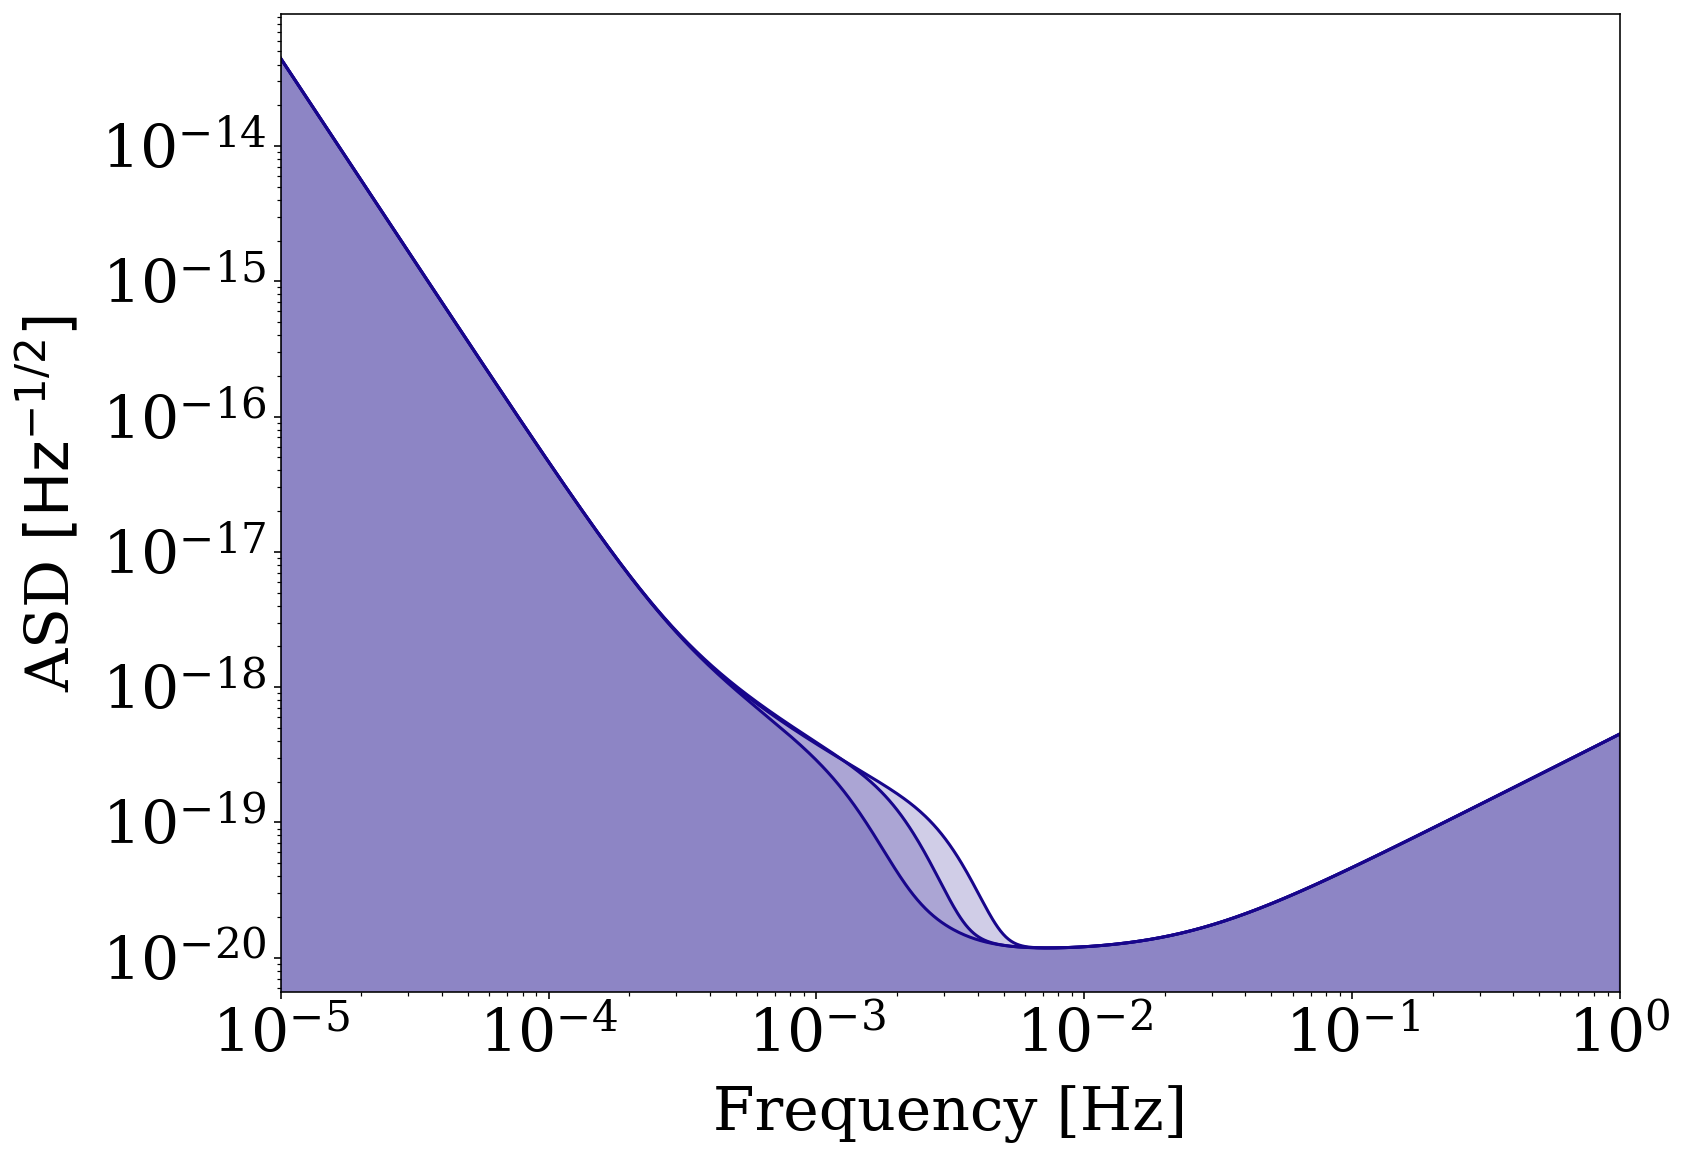

In [431]:
# plot each sensitivity curve on top of each other
fig, ax = sc.plot_sensitivity_curve(sc.LISA_Sn, Tobs=0.5 * u.yr)
fig, ax = sc.plot_sensitivity_curve(sc.LISA_Sn, Tobs=2 * u.yr, fig=fig, ax=ax)
fig, ax = sc.plot_sensitivity_curve(sc.LISA_Sn, Tobs=4 * u.yr, fig=fig, ax=ax)
plt.show()

# Overlay binaries on LISA sensitivity curve
We also include a function to overlay binaries on top of the sensitivity curve. This function makes the assumption that all binaries are stationary in frequency space on the timescale of the mission length. Here we create a random sample of binaries where we give each a mass, frequency and distance in order to calculate the characteristic strain.

In [451]:
# create a random sample of masses, frequencies and distances
SAMPLES = 100
primary_mass = np.random.uniform(0, 10, SAMPLES) * u.Msun
secondary_mass = np.random.rand(SAMPLES) * primary_mass
chirp_mass = str_calc.chirp_mass(primary_mass, secondary_mass)
frequency = np.random.uniform(1e-5, 1e-3, SAMPLES) * u.Hz
distance = np.random.uniform(2, 4, SAMPLES) * u.kpc
eccentricity = np.random.uniform(0.0, 0.05, SAMPLES)

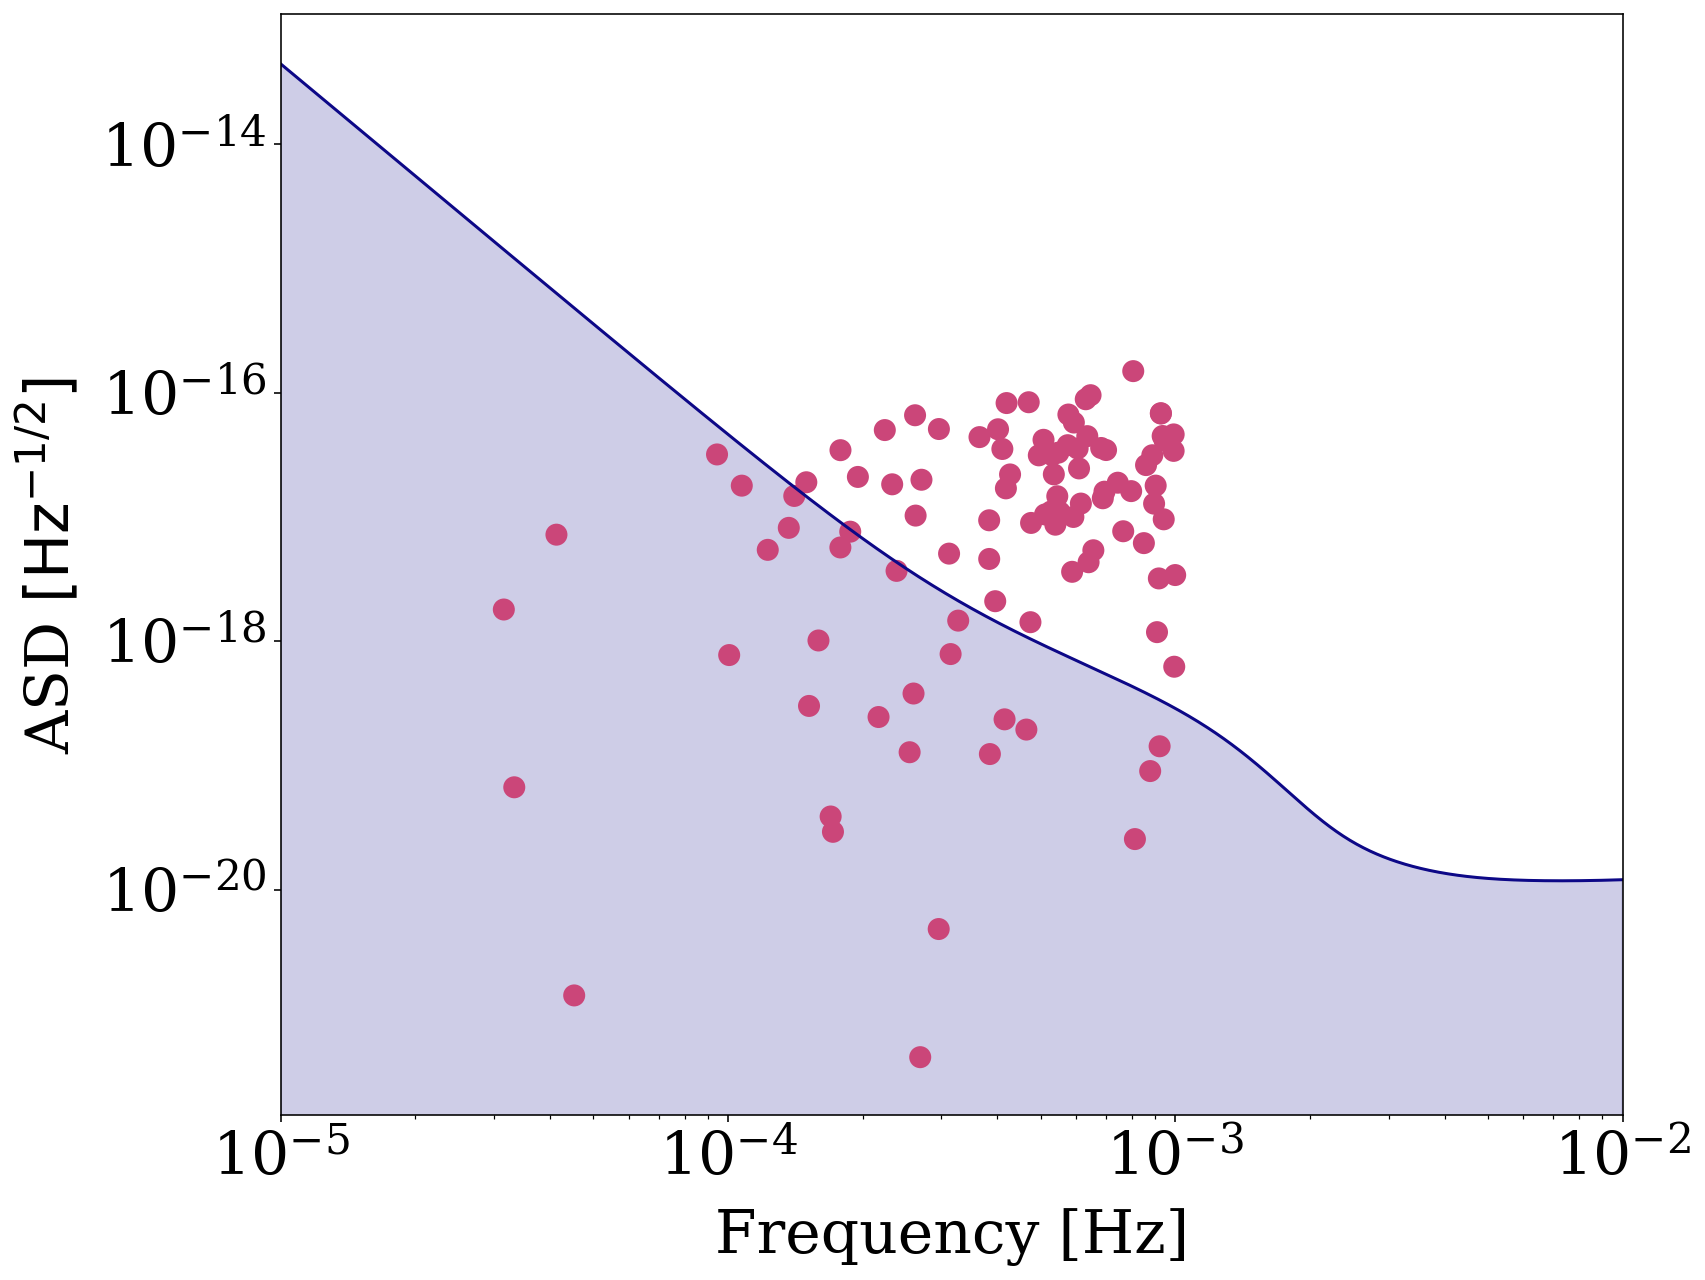

In [452]:
hn = [str_calc.strain(chirp_mass, distance, frequency, n, eccentricity) for n in range(1, 100)]
h = np.sum(hn, axis=0)

# plot sensitivity with binaries overlaid
Tobs = 4 * u.yr
fig, ax = sc.plot_binaries_on_sc(sc.LISA_Sn, frequency, h)
plt.show()

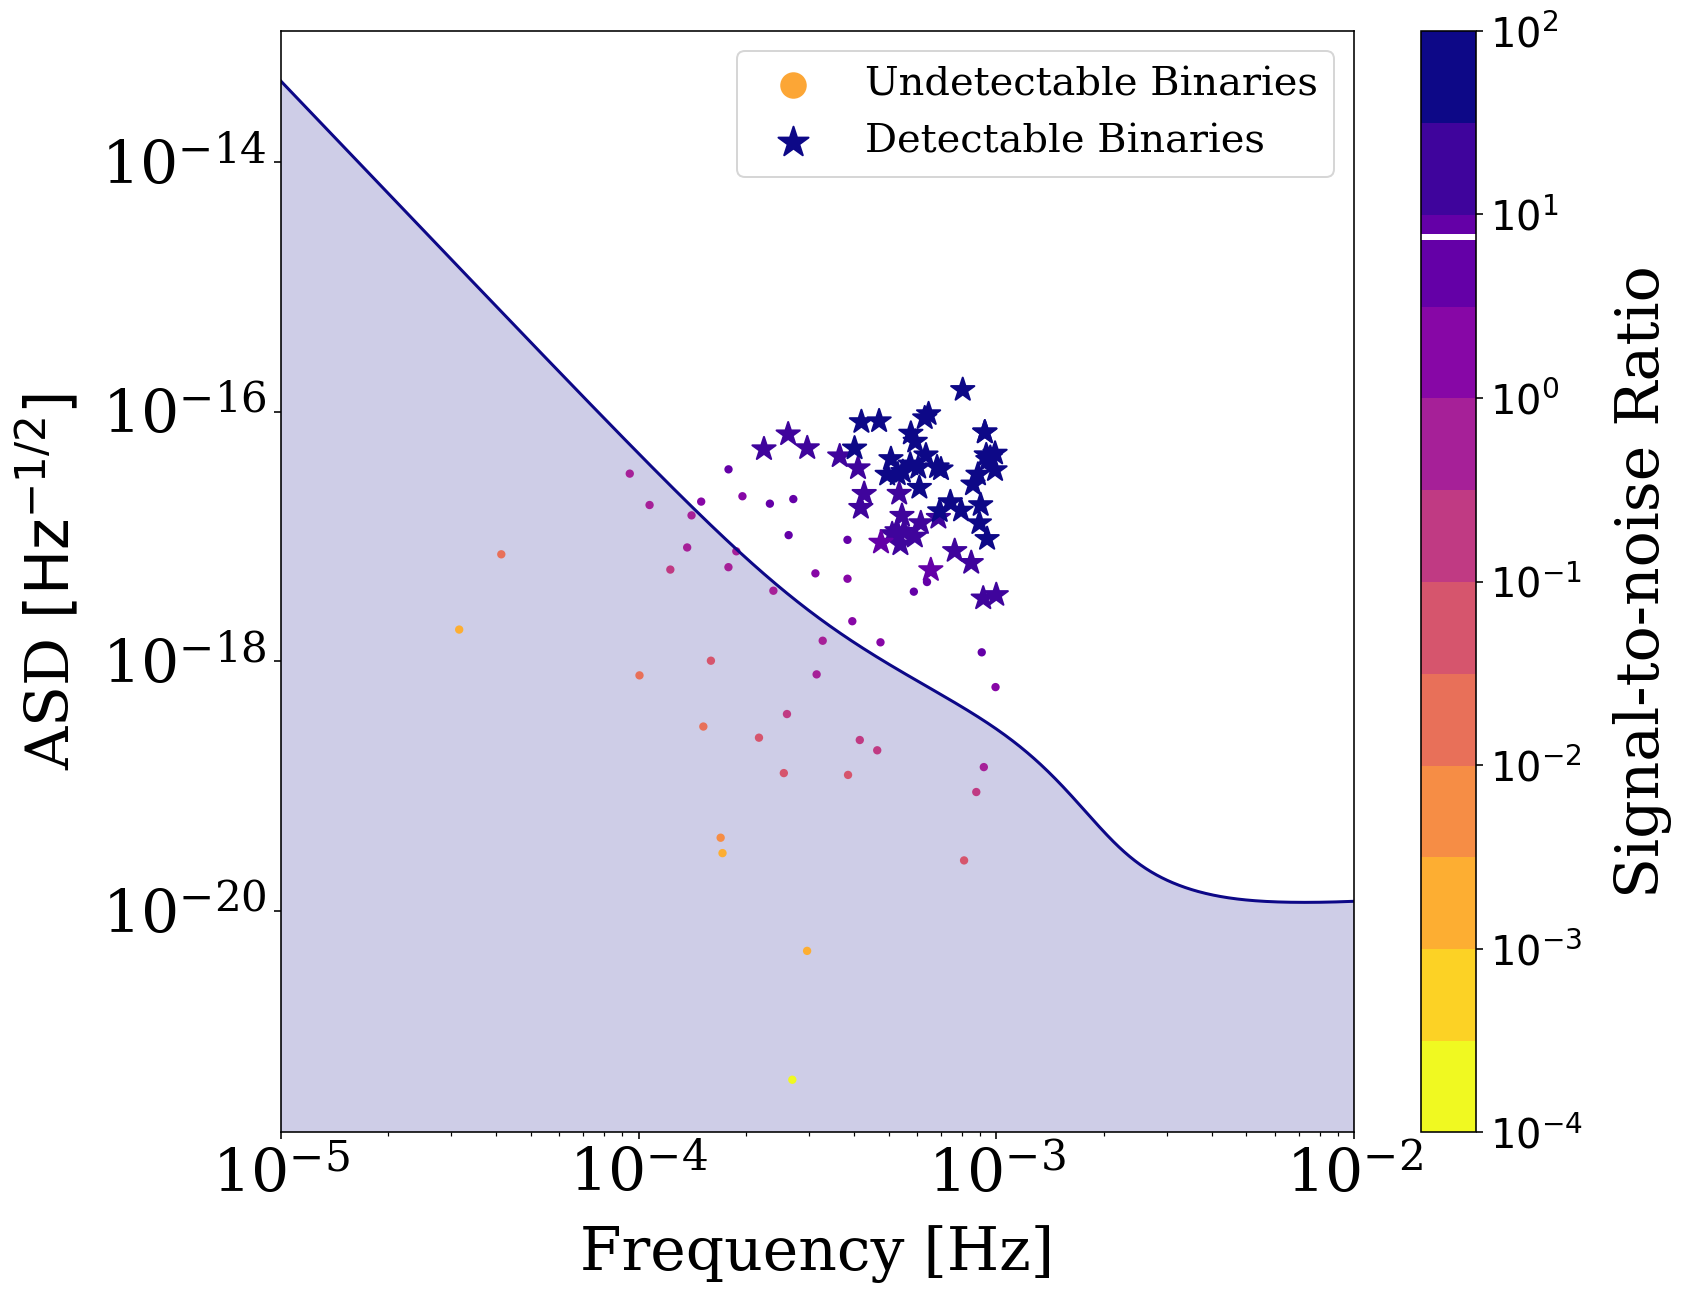

In [454]:
reload(sc)
reload(str_calc)
snr = str_calc.calc_snr_stationary(hn, frequency, sc.LISA_Sn)

fig, ax = sc.plot_binaries_on_sc(Sn=sc.LISA_Sn, frequencies=frequency, 
                                 strain=h, snr=snr)
plt.show()

# Justification behind using stationary approximation
We can use the stationary approximation as long as the frequency doesn't change too much over the LISA mission. Say we set this limit to 0.1%, then we can plot $\dot{f} T_{\rm obs} / f$ to find the fractional change in frequency.

You can see in the plot below that anything that in the red region requires the general SNR equation, but the majority of points above would be valid.

In [120]:
def fdot(Mc, f, e, n):
    return n * 96 / (10 * np.pi) * (c.G * Mc)**(5/3) / c.c**5 * (np.pi * f)**(11/3) * str_calc.F(e)

In [169]:
def pretty_plot(figsize, xlabel, ylabel, fs=20):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.set_xlabel(xlabel, fontsize=fs)
    ax.set_ylabel(ylabel, fontsize=fs)
    ax.tick_params(axis="both", which="major", labelsize=0.7 * fs)
    
    return fig, ax

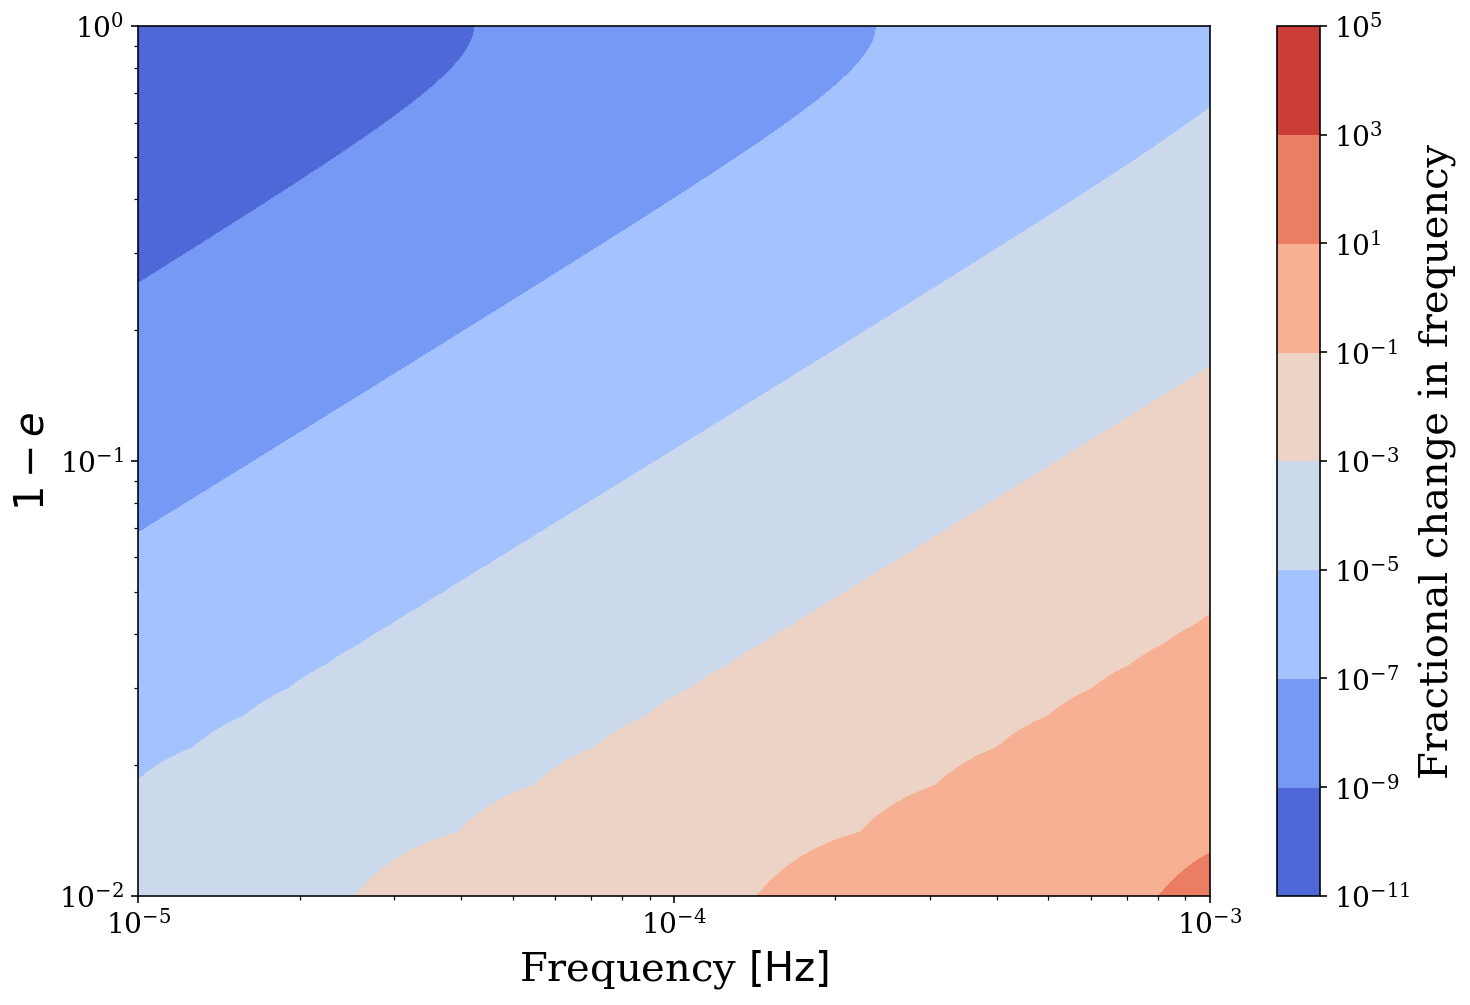

In [450]:
f_range = np.logspace(-5, -3, 250) * u.Hz
e_range = np.linspace(0, 0.99, 250)

F, E = np.meshgrid(f_range, e_range)
fd = fdot(3 * u.Msun, F, E, 2).decompose()
frac_change = (fd * (Tobs.to(u.s)) / F).decompose()

fig, ax = pretty_plot((12, 8), r"Frequency $[\rm Hz]$", r"$1 - e$")

cont = plt.contourf(F, (1 - E), frac_change, cmap="coolwarm", levels=np.logspace(-11, 5, 9), norm=colors.LogNorm())
cbar = plt.colorbar(cont)
cbar.set_label(r"Fractional change in frequency", fontsize=fs)
cbar.ax.tick_params(axis="both", which="major", labelsize=0.7 * fs)

plt.xscale("log")
plt.yscale("log")
plt.show()